In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [8]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_4156/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [9]:
#drop target variable
df = train_data.drop(columns='Claim Injury Type')

In [10]:
#duplicated values
df.duplicated().sum()

18351

In [11]:

only_assembly_date = df.drop(columns=['Assembly Date']).isnull().all(axis=1) & df['Assembly Date'].notnull()


num_only_assembly_date_filled = only_assembly_date.sum()
print(f"Number of rows with only 'Assembly Date' filled: {num_only_assembly_date_filled}")

Number of rows with only 'Assembly Date' filled: 19445


In [12]:
df.isnull().sum()/df.shape[0]*100

Accident Date                           3.898084
Age at Injury                           3.276487
Alternative Dispute Resolution          3.276487
Assembly Date                           0.000000
Attorney/Representative                 3.276487
Average Weekly Wage                     8.104187
Birth Year                              8.176137
C-2 Date                                5.729850
C-3 Date                               68.449174
Carrier Name                            3.276487
Carrier Type                            3.276487
County of Injury                        3.276487
COVID-19 Indicator                      3.276487
District Name                           3.276487
First Hearing Date                     74.590502
Gender                                  3.276487
IME-4 Count                            77.622664
Industry Code                           4.954412
Industry Code Description               4.954412
Medical Fee Region                      3.276487
OIICS Nature of Inju

In [13]:
train_data['C-3 Date'].value_counts(dropna=False)
len(train_data['C-3 Date'].unique())

1649

In [14]:
train_data['First Hearing Date'].value_counts(dropna=False)

print(len(train_data['First Hearing Date'].unique()))

1095


In [15]:
train_data['IME-4 Count'].value_counts(dropna=False)

print(len(train_data['IME-4 Count'].unique()))

42


In [16]:
df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [17]:
#function to transform Y and N into boolean while preserving the NaNs
def transform_strings_in_bool(df, col_names):
    for col_name in col_names:
        df[col_name] = df[col_name].map({'Y': True, 'N': False, np.nan: np.nan})
    return df

In [18]:
# Agreement Reached only has values of  0s and 1s so lets convert it to boolean
df['Agreement Reached'] = df['Agreement Reached'].astype("boolean")

In [19]:

df = transform_strings_in_bool(df, ['Attorney/Representative','COVID-19 Indicator'])
print(df['Attorney/Representative'].unique(), df['COVID-19 Indicator'].unique())

[False True nan] [False nan True]


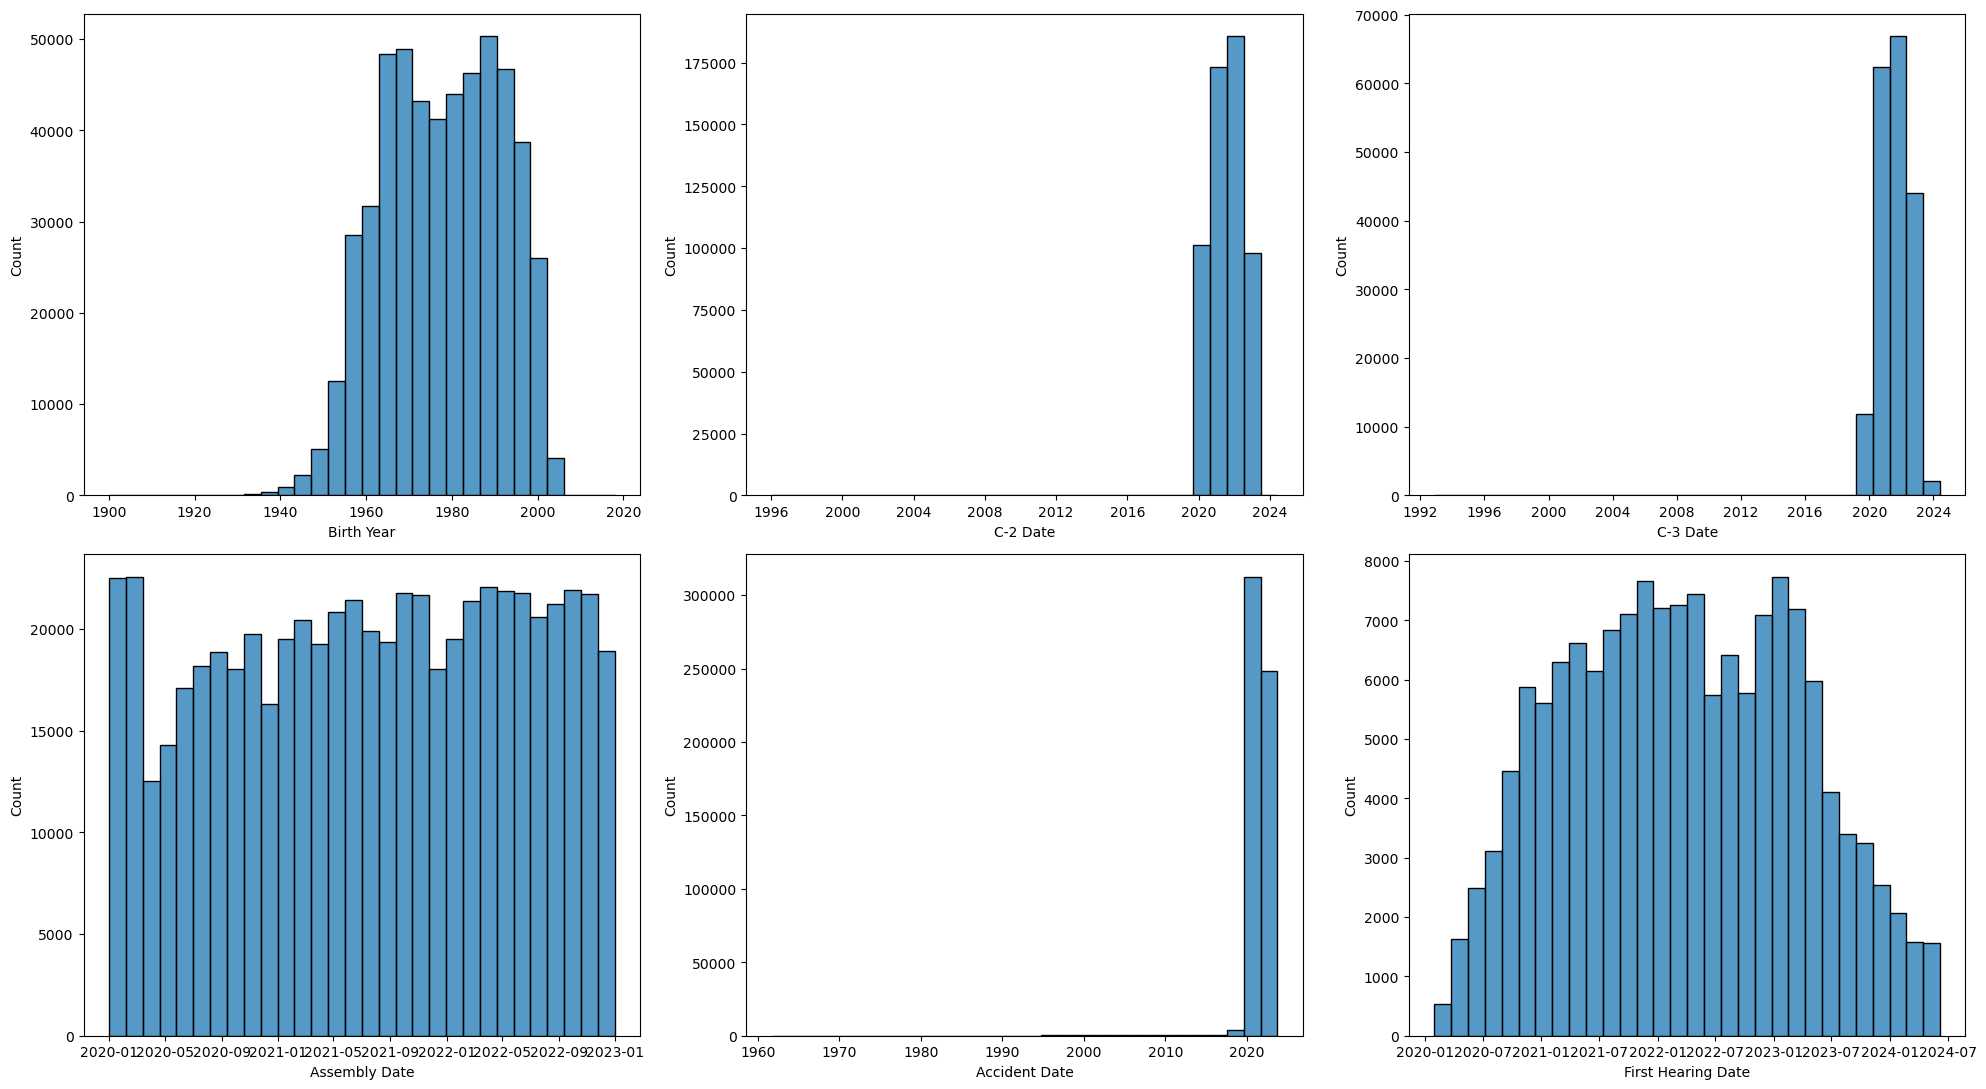

In [20]:
outlier_date = train_data.copy()
for col in outlier_date.columns:
    if 'Date' in col:
        outlier_date[col] = pd.to_datetime(outlier_date[col], format='%Y-%m-%d')
    elif 'Year' in col:
        outlier_date[col] = outlier_date[col].replace(0.0, np.nan)
        outlier_date[col] = pd.to_datetime(outlier_date[col].dropna().astype(int).astype(str), format='%Y', errors='coerce')

features = ['Birth Year','C-2 Date','C-3 Date','Assembly Date','Accident Date','First Hearing Date']

sp_rows = 2
sp_cols = 3

fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(outlier_date[feat], ax=ax, bins=30)


title = "Datetime Variables' Histograms"

plt.show()

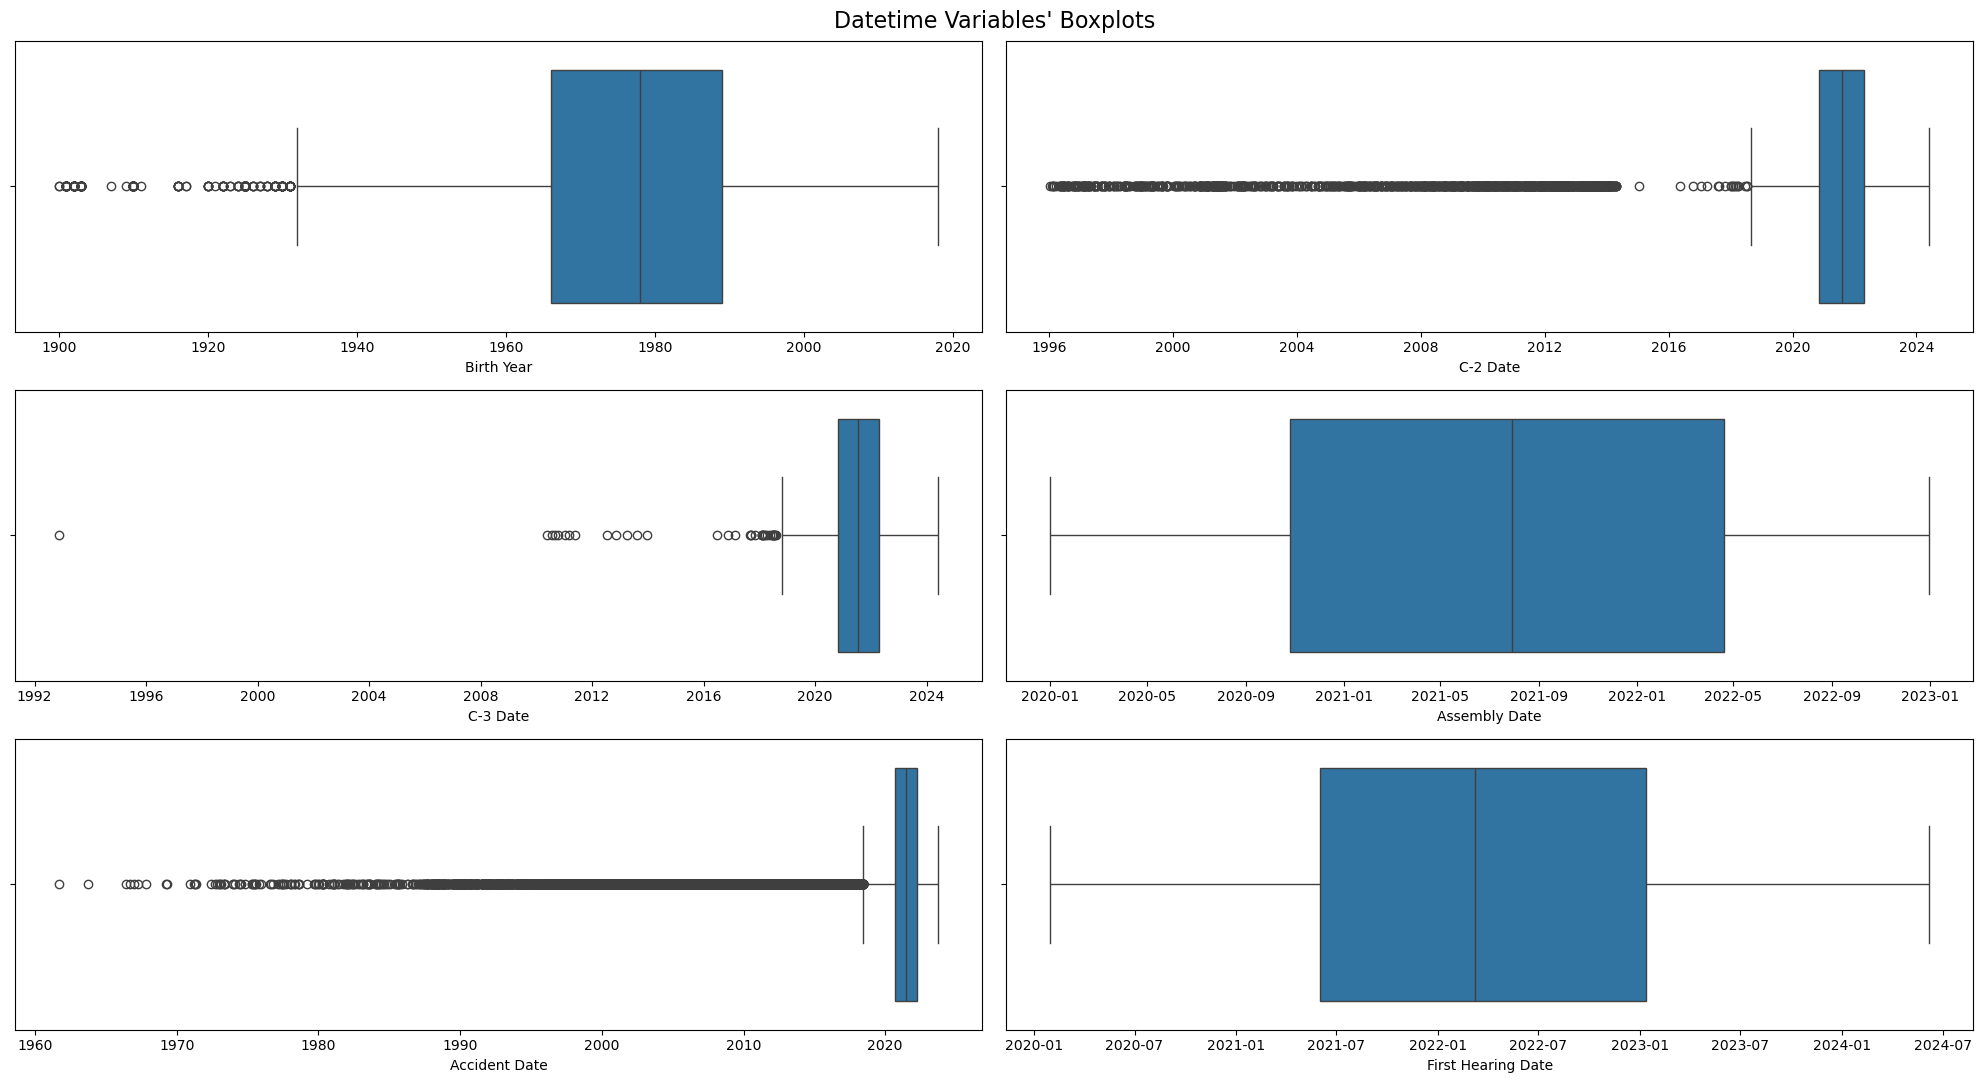

In [21]:
sp_rows = 3
sp_cols = 2

fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x=outlier_date[feat], ax=ax)


title = "Datetime Variables' Boxplots"
plt.suptitle(title, fontsize=16)
plt.show()

In [22]:
df['Accident Date'].head()

Claim Identifier
5393875      2019-12-30
5393091      2019-08-30
5393889      2019-12-06
957648180           NaN
5393887      2019-12-30
Name: Accident Date, dtype: object

In [23]:
# converts the date columns to datetime format
for col in train_data.columns:
    # fist we convert all columns containing the word 'Date' to datetime format
    if 'Date' in col:
        train_data[col] = pd.to_datetime(train_data[col], format='%Y-%m-%d')


train_data

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaT,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
5393091,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
5393889,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,1A. PRIVATE,4. TEMPORARY,ORANGE,N,ALBANY,NaT,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
957648180,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5393887,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,2A. SIF,2. NON-COMP,DUTCHESS,N,ALBANY,NaT,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327160035,NaT,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6165075,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaT,TECHNOLOGY INSURANCE CO. INC.,1A. PRIVATE,2. NON-COMP,SULLIVAN,N,BINGHAMTON,NaT,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
249875936,NaT,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
def convert_dates_to_timestamps(df):
    """
    Converts all columns in the DataFrame that contain 'Date' in their name
    to timestamps (seconds since epoch).

    Parameters:
    df (pd.DataFrame): The DataFrame containing date columns.

    Returns:
    pd.DataFrame: DataFrame with 'Date' columns converted to timestamps.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    for col in df.columns:
        if 'Date' in col:
            # Convert the column to datetime, coerce invalid parsing to NaT
            df[col] = pd.to_datetime(df[col], errors='coerce')

#Convert to timestamp only for valid datetime values
            df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

    return df

In [25]:
train_data = convert_dates_to_timestamps(train_data)
test_data = convert_dates_to_timestamps(test_data)

train_data.describe(include='all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
count,5.703370e+05,574026.000000,574026,5.934710e+05,574026,5.453750e+05,544948.000000,5.594660e+05,1.872450e+05,574026,574026,574026,574026,574026,574026,1.507980e+05,574026,132803.000000,564068.000000,564068,574026,0.0,558386.000000,558386,558369.000000,558369,556944.000000,556944,545389,574026.000000,574026,574026.000000
unique,NaN,NaN,3,NaN,2,NaN,NaN,NaN,NaN,2046,8,8,63,2,8,NaN,4,NaN,NaN,20,5,NaN,NaN,74,NaN,56,NaN,54,10060,NaN,1,NaN
top,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,NaN,M,NaN,NaN,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,NaN,LIFTING,NaN,STRAIN OR TEAR,NaN,LOWER BACK AREA,11236,NaN,Not Work Related,NaN
freq,NaN,NaN,571412,NaN,392291,NaN,NaN,NaN,NaN,111144,285368,291078,60430,546505,270779,NaN,335218,NaN,NaN,114339,265981,NaN,NaN,46610,NaN,153373,NaN,51862,3302,NaN,574026,NaN
mean,1.619644e+09,42.114270,NaN,1.626665e+09,NaN,4.910883e+02,1886.767604,1.626466e+09,1.627335e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.647666e+09,NaN,3.207337,58.645305,NaN,NaN,NaN,54.381143,NaN,41.013839,NaN,39.738146,NaN,NaN,0.046665,NaN,3.006559
std,5.908936e+07,14.256432,NaN,2.721032e+07,NaN,6.092918e+03,414.644423,3.513655e+07,2.832608e+07,NaN,NaN,NaN,NaN,NaN,NaN,3.144186e+07,NaN,2.832303,19.644175,NaN,NaN,NaN,25.874281,NaN,22.207521,NaN,22.365940,NaN,NaN,0.210921,NaN,2.000801
min,-2.625696e+08,0.000000,NaN,1.577837e+09,NaN,0.000000e+00,0.000000,8.214048e+08,7.216128e+08,NaN,NaN,NaN,NaN,NaN,NaN,1.580342e+09,NaN,1.000000,11.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000,NaN,0.000000
25%,1.600042e+09,31.000000,NaN,1.603670e+09,NaN,0.000000e+00,1965.000000,1.604621e+09,1.603757e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.622506e+09,NaN,1.000000,45.000000,NaN,NaN,NaN,31.000000,NaN,16.000000,NaN,33.000000,NaN,NaN,0.000000,NaN,1.000000
50%,1.624752e+09,42.000000,NaN,1.627517e+09,NaN,0.000000e+00,1977.000000,1.628467e+09,1.626826e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.646784e+09,NaN,2.000000,61.000000,NaN,NaN,NaN,56.000000,NaN,49.000000,NaN,38.000000,NaN,NaN,0.000000,NaN,3.000000
75%,1.647821e+09,54.000000,NaN,1.650326e+09,NaN,8.410000e+02,1989.000000,1.650931e+09,1.650413e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.673395e+09,NaN,4.000000,71.000000,NaN,NaN,NaN,75.000000,NaN,52.000000,NaN,53.000000,NaN,NaN,0.000000,NaN,5.000000


In [26]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]
X_test = test_data[~(test_data.drop(columns=['Assembly Date']).isna().all(axis=1) & test_data['Assembly Date'].notna())]

In [27]:
only_assembly_date = train_data.drop(columns=['Assembly Date']).isnull().all(axis=1) & df['Assembly Date'].notnull()


num_only_assembly_date_filled = only_assembly_date.sum()
print(f"Number of rows with only 'Assembly Date' filled: {num_only_assembly_date_filled}")

Number of rows with only 'Assembly Date' filled: 0


In [28]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y = train_data['Claim Injury Type']
wcb_decision = train_data['WCB Decision']
agreement_reached = train_data['Agreement Reached']

In [29]:
y.isna().sum()

0

In [30]:
# split the data into training and testing sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [31]:
# drop OIICS Nature of Injury Description
X_train = X_train.drop(columns=['OIICS Nature of Injury Description'])
X_val = X_val.drop(columns=['OIICS Nature of Injury Description'])
X_test = X_test.drop(columns=['OIICS Nature of Injury Description'])

In [32]:
# KNNNNNb

In [33]:
X_train_knn = X_train.copy()
X_val_knn = X_val.copy()
X_test_knn = X_test.copy()

In [34]:
X_train_knn["IME-4 Count"].fillna(0, inplace=True)
X_val_knn["IME-4 Count"].fillna(0, inplace=True)
X_test_knn["IME-4 Count"].fillna(0, inplace=True)

/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_4156/4214573977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_knn["IME-4 Count"].fillna(0, inplace=True)
/var/folders/cb/8gnf1rrd7914vbmqtgrt2mmm0000gn/T/ipykernel_4156/4214573977.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [35]:
X_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 5785935 to 6027959
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Accident Date                      456264 non-null  float64
 1   Age at Injury                      459220 non-null  float64
 2   Alternative Dispute Resolution     459220 non-null  object 
 3   Assembly Date                      459220 non-null  float64
 4   Attorney/Representative            459220 non-null  object 
 5   Average Weekly Wage                436244 non-null  float64
 6   Birth Year                         435978 non-null  float64
 7   C-2 Date                           447585 non-null  float64
 8   C-3 Date                           149655 non-null  float64
 9   Carrier Name                       459220 non-null  object 
 10  Carrier Type                       459220 non-null  object 
 11  County of Injury                   45

In [36]:
X_train_knn.isnull().sum()

Accident Date                          2956
Age at Injury                             0
Alternative Dispute Resolution            0
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                   22976
Birth Year                            23242
C-2 Date                              11635
C-3 Date                             309565
Carrier Name                              0
Carrier Type                              0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                   338679
Gender                                    0
IME-4 Count                               0
Industry Code                          7976
Industry Code Description              7976
Medical Fee Region                        0
WCIO Cause of Injury Code             12494
WCIO Cause of Injury Description      12494
WCIO Nature of Injury Code      

In [37]:
# Step 1: Identify Columns with Missing Values
missing_columns = X_train_knn.columns[X_train_knn.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index(['Accident Date', 'Average Weekly Wage', 'Birth Year', 'C-2 Date',
       'C-3 Date', 'First Hearing Date', 'Industry Code',
       'Industry Code Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code'],
      dtype='object')


In [38]:
# List of datasets
datasets = {'train': X_train_knn, 'val': X_val_knn, 'test': X_test_knn}
label_encoders = {}  # Store encoders for each column

# Step 1: Ensure consistent encoding for all categorical columns
for column in X_train_knn.columns:
    # Check if the column contains any non-numeric (string) values
    if X_train_knn[column].dtype == 'object' or X_train_knn[column].apply(lambda x: isinstance(x, str)).any():
        
        # Initialize Label Encoder and fit on the training data
        le = LabelEncoder()
        # Convert all entries to string to ensure consistent encoding
        X_train_knn[column] = X_train_knn[column].astype(str)
        X_train_knn[column] = le.fit_transform(X_train_knn[column])
        
        # Store encoder for future use
        label_encoders[column] = le

        # Apply the encoder to validation and test datasets with unseen value handling
        for name in ['val', 'test']:
            # Replace any unseen labels with NaN to avoid KeyErrors
            datasets[name][column] = datasets[name][column].astype(str).apply(lambda x: x if x in le.classes_ else np.nan)
            # Add NaN as a class label to handle unseen values
            le.classes_ = np.append(le.classes_, np.nan)
            # Transform the column in the current dataset
            datasets[name][column] = le.transform(datasets[name][column])

In [39]:
# Step 2: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")


print("Knn completed on training, validation, and test sets.")

NameError: name 'KNNImputer' is not defined